# Multihead ResNET (Multi-Task Learning)

1) The last layer of the pretrained resnet is removed. Linear layers(Heads) are added for each attribute.
2) Both the last linear layer for each attribute and the convolution layer is trainable.
3) Single training loop for training classification of multiple attributes. Eg. Men Tshirt, all 5 attributes are trained at once.
4) Advantage: Cross-learning among attributes. Con we found: More data is required. 



In [14]:
########### Just run this ############

import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated")
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from torchvision.models import resnet18,resnet50, ResNet18_Weights,ResNet34_Weights, VGG16_Weights, resnet50, ResNet50_Weights 



# Define the dataset path and CSV file
image_folder = '/home/ravindra/meesho/train_images'
csv_path = '/home/ravindra/meesho/_vikas_/train_filled_30.csv' #doesnt include Categoru column

# Load the data
df_all = pd.read_csv(csv_path)

Categories = list(df_all['Category'].unique())
Categories

Attributes = {}
num_attr = [5,10,9,8,10]
for i,cat in enumerate(Categories):
    Attributes[cat] = [f'attr_{i}' for i in range(1,num_attr[i]+1)]
Attributes
for key in list(Attributes.keys()):
    df_all[df_all['Category'] == key] = df_all[df_all['Category'] == key].dropna(subset=Attributes[key],axis=0)
df_all = df_all.dropna(subset='id')
df_all['id'] = df_all['id'].astype(int)
df_all['len'] = df_all['len'].astype(int)


class SareeDataset(Dataset):
    def __init__(self, dataframe, image_folder,attr, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform
        self.attr = attr

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = str(self.dataframe.iloc[idx, 0]).zfill(6) + '.jpg'
        img_path = os.path.join(self.image_folder, img_id)
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Load labels for each attribute
        labels = self.dataframe[self.attr].iloc[idx] # Get all attribute labels as a list
        # print(labels)
        labels = torch.tensor(labels.iloc[:], dtype=torch.long)  # Convert to tensor
        
        return image, labels

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloader


# Define the multi-head model
class MultiHeadResNet(nn.Module):
    def __init__(self, num_classes_list):
        super(MultiHeadResNet, self).__init__()
        
        # Load a pretrained ResNet50 model
        self.base_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Remove the original fully connected layer
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])

        # Create separate heads for each attribute
        self.heads = nn.ModuleList([nn.Linear(2048, num_classes) for num_classes in num_classes_list])
        

        for name, param in self.base_model[-1].named_parameters():  # base_model[0] is the first conv layer
            param.requires_grad = True
        #### 
        # self.linear = nn.Linear(2048,512)
        ####
    def forward(self, x):
        # Pass input through ResNet base model
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        #####
        # x = torch.relu(self.linear(x))
        #####
        # Pass through each head
        outputs = [head(x) for head in self.heads]
        return outputs
df_train,df_test = train_test_split(df_all, train_size=0.8, random_state=42)




# Updated evaluation function with normalized confusion matrix
def evaluate_model(model, dataloader, label_encoders,attribute_columns,category, device):
    model.eval()
    all_preds = {attr: [] for attr in attribute_columns}
    all_labels = {attr: [] for attr in attribute_columns}
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = [label.to(device) for label in labels.T]  # Separate labels for each head
            
            # Get predictions
            outputs = model(images)
            preds = [torch.argmax(output, dim=1).cpu().numpy() for output in outputs]
            
            # Store predictions and true labels
            for i, attr in enumerate(attribute_columns):
                all_preds[attr].extend(preds[i])
                all_labels[attr].extend(labels[i].cpu().numpy())
    

        # Set the number of rows and columns for the subplots
        n_cols = 3  # Adjust this based on the number of attributes and layout preference
        n_rows = -(-len(attribute_columns) // n_cols)  # Calculate rows needed (ceil division)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))  # Adjust figure size as needed
        axes = axes.flatten()  # Flatten the 2D axes array for easy iteration

        for i, attr in enumerate(attribute_columns):
            acc = accuracy_score(all_labels[attr], all_preds[attr])
            f1 = f1_score(all_labels[attr], all_preds[attr], average='weighted')
            print(f"{attr} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
            
            # Compute confusion matrix and normalize it
            cm = confusion_matrix(all_labels[attr], all_preds[attr])
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
            # Plot normalized confusion matrix
            sns.heatmap(
                cm_normalized, 
                annot=True, 
                fmt=".2f", 
                cmap="Blues",
                xticklabels=label_encoders[f'{category}_{attr}'].classes_, 
                yticklabels=label_encoders[f'{category}_{attr}'].classes_,
                ax=axes[i]  # Use the correct subplot
            )
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("True")
            axes[i].set_title(f"Normalized Confusion Matrix for {category} {attr}")

        # Handle unused subplots (if attributes < n_rows * n_cols)
        if len(attribute_columns) < len(axes):
            for j in range(len(attribute_columns), len(axes)):
                fig.delaxes(axes[j])  # Remove extra subplots only if they exist

        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()

# Run evaluation on the validation/test set
# evaluate_model(models_store[Categories[i]], dataloader, label_encoders,Attributes[Categories[i]],category = Categories[i], device=device)

  0%|          | 0/2 [00:00<?, ?it/s]


🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [1/5], Loss: 1.8783, val_loss: 1.1264

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [2/5], Loss: 0.8435, val_loss: 0.9489

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [3/5], Loss: 0.5265, val_loss: 0.8919

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [4/5], Loss: 0.3381, val_loss: 1.0413

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

100%|██████████| 5/5 [00:36<00:00,  7.25s/it]

Epoch [5/5], Loss: 0.2440, val_loss: 1.0091
Training complete! forMen Tshirts


attr_1 - Accuracy: 0.7794, F1 Score: 0.7786
attr_2 - Accuracy: 0.9936, F1 Score: 0.9936
attr_3 - Accuracy: 0.9820, F1 Score: 0.9820
attr_4 - Accuracy: 0.9215, F1 Score: 0.9220
attr_5 - Accuracy: 0.9894, F1 Score: 0.9891


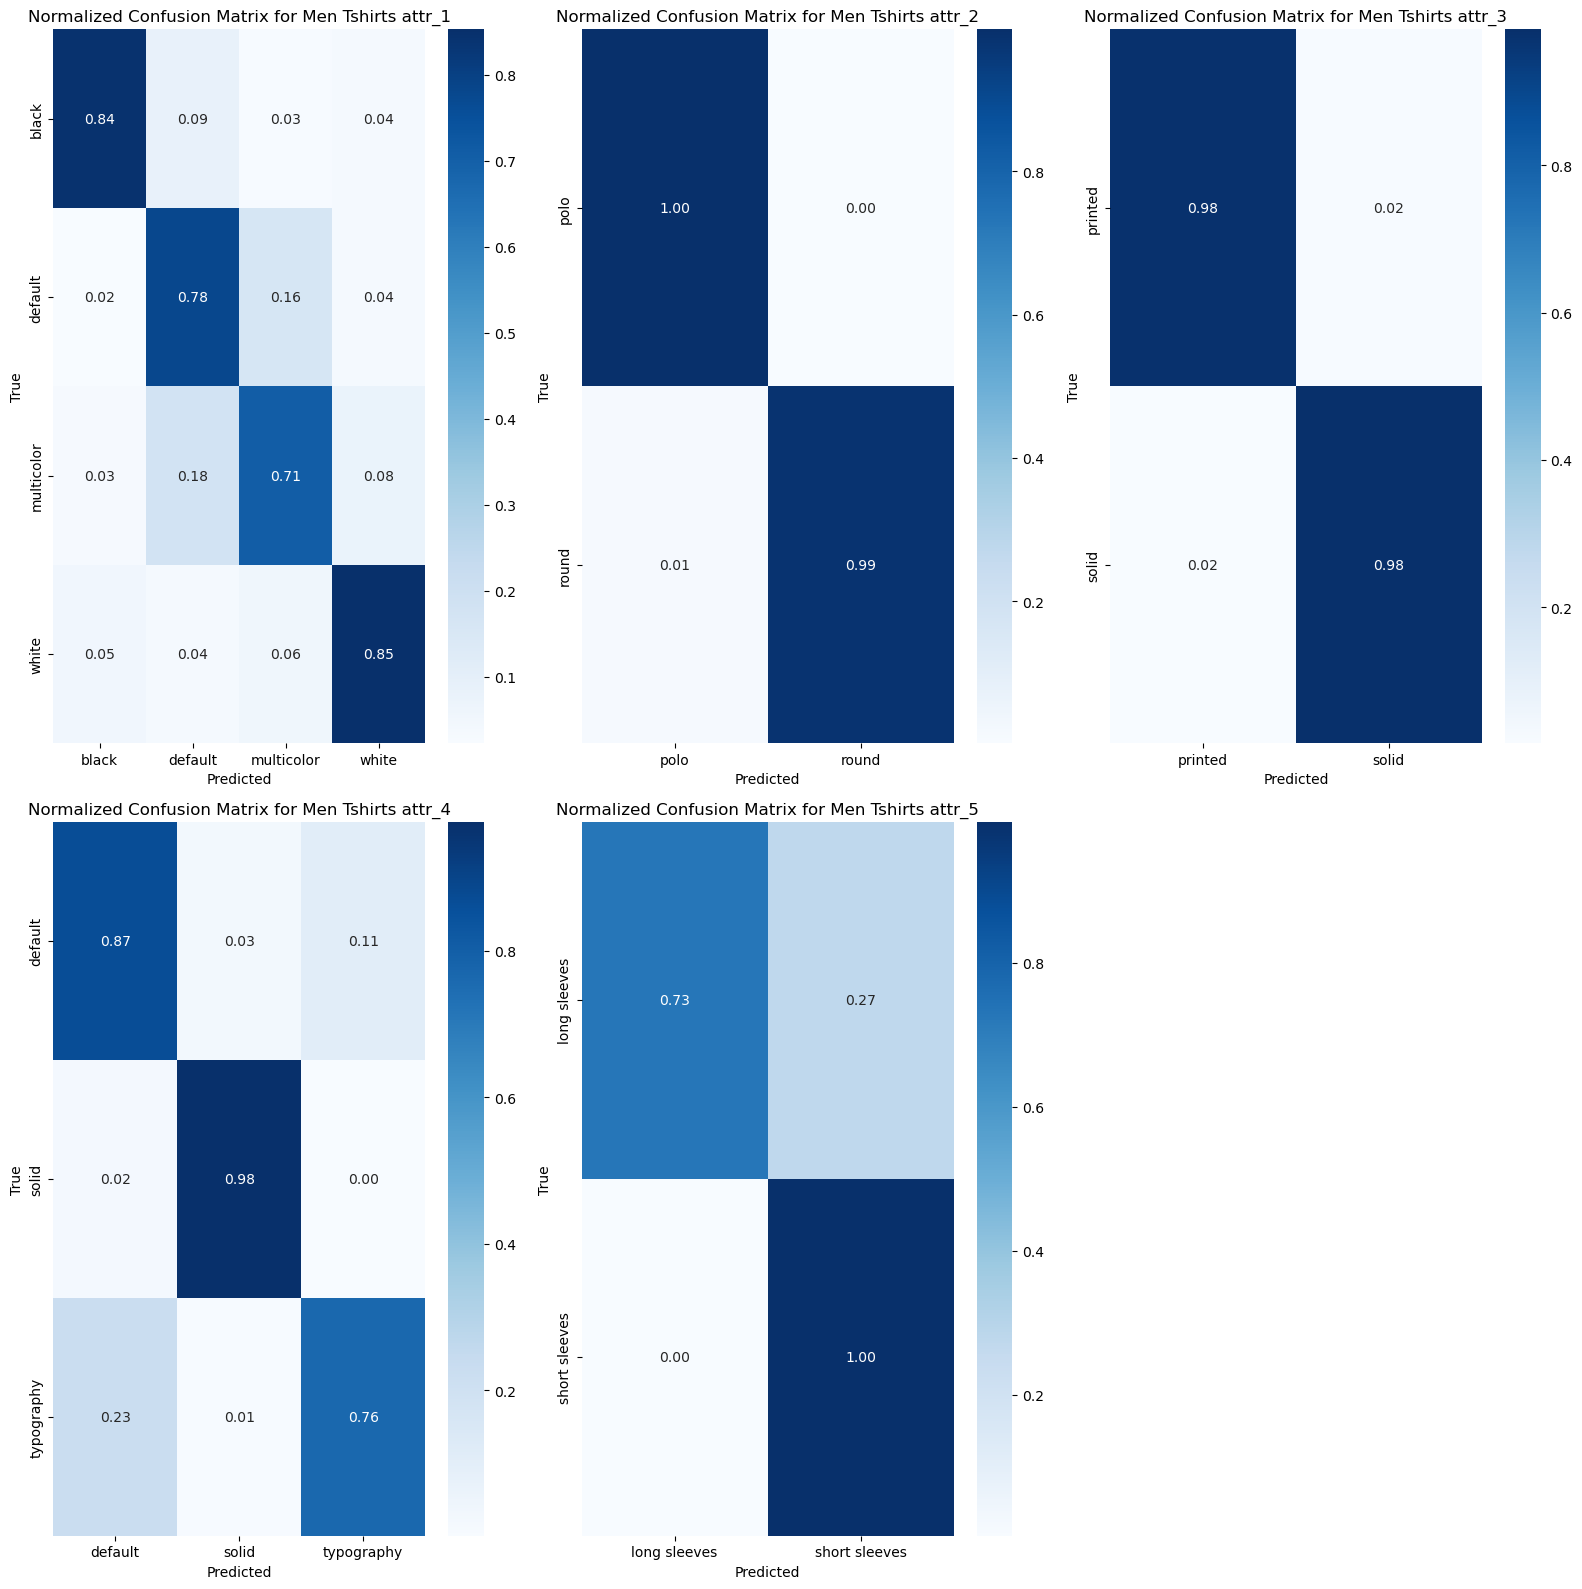

 50%|█████     | 1/2 [00:39<00:39, 39.23s/it]


🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [1/5], Loss: 9.8327, val_loss: 7.3215

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [2/5], Loss: 5.9891, val_loss: 5.5973

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [3/5], Loss: 4.2894, val_loss: 4.8284

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

Epoch [4/5], Loss: 3.2461, val_loss: 4.4626

🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️🚣🏼‍♂️

100%|██████████| 5/5 [00:32<00:00,  6.56s/it]

Epoch [5/5], Loss: 2.4740, val_loss: 4.3551
Training complete! forWomen Tops & Tunics


attr_1 - Accuracy: 0.7481, F1 Score: 0.7385
attr_2 - Accuracy: 0.8127, F1 Score: 0.8051
attr_3 - Accuracy: 0.8837, F1 Score: 0.8838
attr_4 - Accuracy: 0.8140, F1 Score: 0.7985
attr_5 - Accuracy: 0.9858, F1 Score: 0.9787
attr_6 - Accuracy: 0.9457, F1 Score: 0.9444
attr_7 - Accuracy: 0.8643, F1 Score: 0.8638
attr_8 - Accuracy: 0.8850, F1 Score: 0.8811
attr_9 - Accuracy: 0.8798, F1 Score: 0.8735
attr_10 - Accuracy: 0.6899, F1 Score: 0.6850


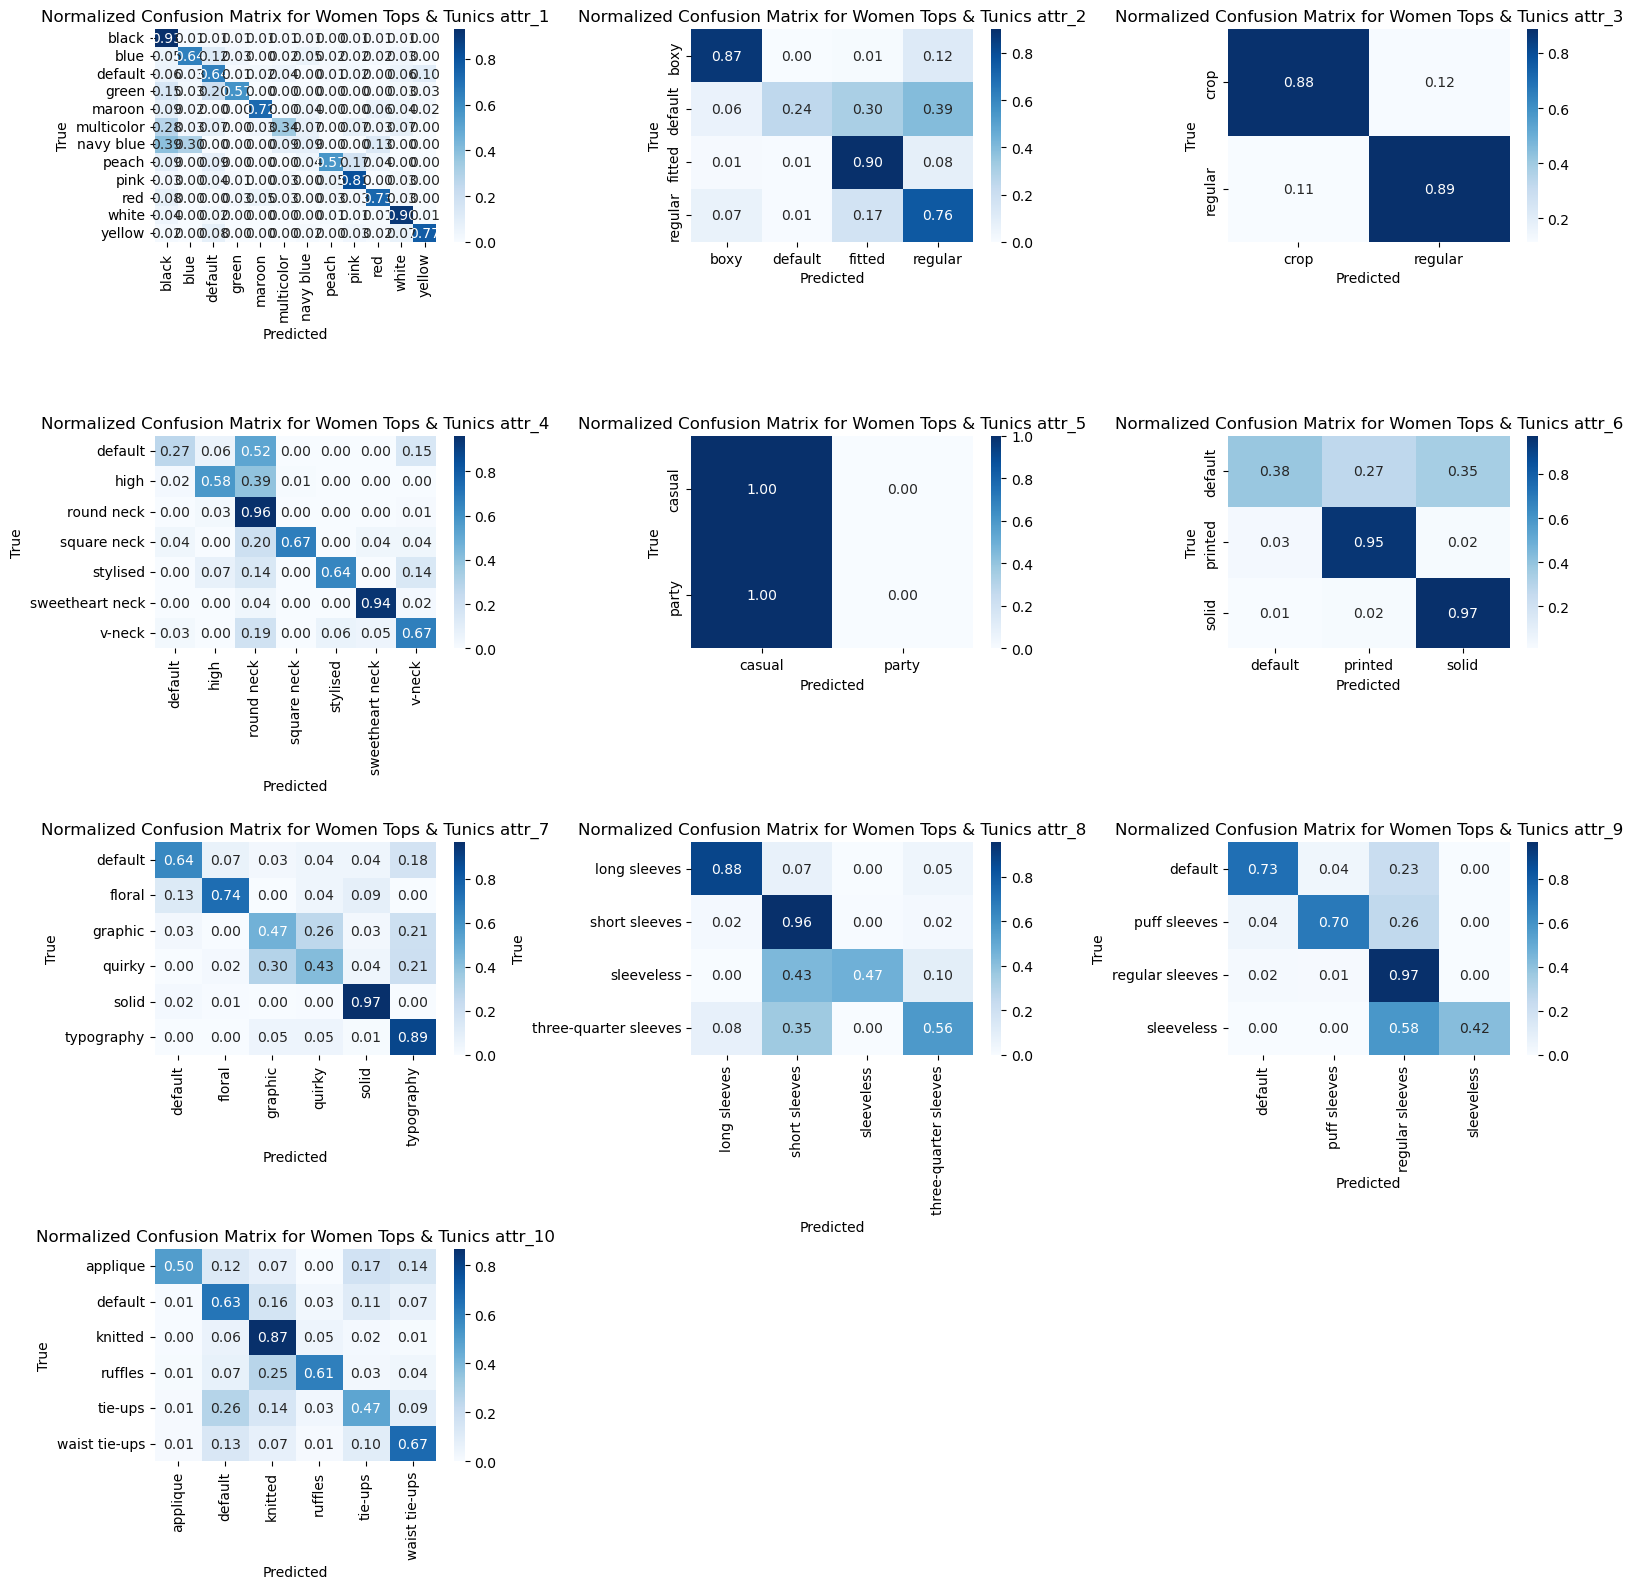

100%|██████████| 2/2 [01:17<00:00, 38.58s/it]


In [15]:

# Unique values for each attribute for label encoding
# attribute_columns = df.columns[1:]  # Exclude 'id'
# which_category= 'Sarees'
Sub_cat  = ['Men Tshirts', 'Women Tops & Tunics']
label_encoders = {}
models_store = {}
dataloader_dict = {}
valoader_dict = {}
for cat in tqdm(Sub_cat):
    df = df_all[df_all['Category'] == cat].copy(deep=True)
# Apply label encoding for each attribute

    for attr in Attributes[cat]:
        le = LabelEncoder()
        df.loc[:,attr] = le.fit_transform(df[attr].fillna('missing'))  # Fill missing values if any
        label_encoders[f'{cat}_{attr}'] = le

    # Define a custom dataset for loading images and labels
    

    # Define the number of classes for each attribute based on unique values
    num_classes_list = [len(df[attr].unique()) for attr in  Attributes[cat]]

    # Initialize the model
    model = MultiHeadResNet(num_classes_list=num_classes_list)

    df_train,df_val = train_test_split(df, train_size=0.8, random_state=42)

    dataset = SareeDataset(df_train, image_folder,attr=Attributes[cat], transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=32)
    dataloader_dict[cat] = dataloader


    val_dataset = SareeDataset(df_val, image_folder,attr=Attributes[cat], transform=transform)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False,num_workers=32)
    valoader_dict[cat] = val_dataloader
    # X_train, X_val, y_train, y_val = train_test_split(df, train_size=0.8 random_state=42)

    # Set all parameters to be trainable
    for param in model.parameters():
        param.requires_grad = True

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    num_epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        count = 0
        print()
        for images, labels in dataloader:
            count+=1
            if(count%2 == 0):
                print('🚣🏼‍♂️',end='')
            # print(count)
            images = images.to(device)
            # print(labels[0].shape)
            labels = [label.to(device) for label in labels.T]  # Separate labels for each head

            # Forward pass
            outputs = model(images)

            loss = sum(criterion(output, label) for output, label in zip(outputs, labels))  # Sum losses for each head
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()


        for images, labels in val_dataloader:
            count+=1
            # print(count)
            images = images.to(device)
            # print(labels[0].shape)
            labels = [label.to(device) for label in labels.T]  # Separate labels for each head

            # Forward pass
            outputs = model(images)
            loss_val = sum(criterion(output, label) for output, label in zip(outputs, labels))  # Sum losses for each head
        
            running_val_loss += loss_val.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, val_loss: {running_val_loss/len(val_dataloader):.4f}")

    print(f"Training complete! for{cat}")
    models_store[cat] = model
    # Calculate accuracy, F1 score, and plot normalized confusion matrix for each attribute

    # Run evaluation on the validation/test set
    # evaluate_model(models_store[cat], dataloader, label_encoders,Attributes[cat],category = cat, device=device)
    evaluate_model(models_store[cat], val_dataloader, label_encoders,Attributes[cat],category = cat, device=device)

# Convo-XGBoost/SVM

1) Train a ResNET50 keeping the last convolution layer and fully connected trainable.
2) Last fully connecting layer is removed and an XGBoost or SVM can be used. 


Note: The accuracies are wrong, to get the correct ones we need k-fold cross validation, since the data is sparse.

In [1]:
import time
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import seaborn as sns

import os
import matplotlib.pyplot as plt
import pandas as pd



batch_size = 64
############ Preprocessing

#loading data 
path = '/home/ravindra/meesho/cropped_30k_images'  ### path to images

# Path to resnet weights.
path_to_res = '/home/ravindra/meesho/MODELS/duplicate_removed_cropped_Run_RESNET[50]_OverSamplingFalse_unfreeze[3]_RESNET_MODELS/Models'



# path = '/home/ravindra/meesho/cropped_30k_images'
filenames = [filen for filen in os.listdir(f"{path}") if 'jpg' in filen]

Attribute_list = pd.read_parquet('/home/ravindra/meesho/category_attributes.parquet')

train_atributes = pd.read_csv('/home/ravindra/meesho/_vikas_/train_filled_30.csv')

#categories name
class_names = train_atributes['Category'].unique()




#filling nan to missing values
filename_classes = {}
for i in range(len(class_names)):
    filename_classes[class_names[i]] = (train_atributes[train_atributes['Category']==class_names[i]]['id'].values).astype('int32')

train_men_tshirt = train_atributes[train_atributes['Category']==class_names[0]].fillna('nan')
train_sarees = train_atributes[train_atributes['Category']==class_names[1]].fillna('nan')
train_kurtis = train_atributes[train_atributes['Category']==class_names[2]].fillna('nan')
train_women_tshirt = train_atributes[train_atributes['Category']==class_names[3]].fillna('nan')
train_women_top_tunics = train_atributes[train_atributes['Category']==class_names[4]].fillna('nan')





# Drop columns which has only nan values, i.e unique() has length 1 and the item is 'nan'
for i in range(10):
    if(len(train_men_tshirt[f'attr_{i+1}'].unique())==1):
        train_men_tshirt.drop(columns=[f'attr_{i+1}'],inplace=True)
    if(len(train_sarees[f'attr_{i+1}'].unique())==1):
        train_sarees.drop(columns=[f'attr_{i+1}'],inplace=True)
    if(len(train_kurtis[f'attr_{i+1}'].unique())==1):
        train_kurtis.drop(columns=[f'attr_{i+1}'],inplace=True)
    if(len(train_women_tshirt[f'attr_{i+1}'].unique())==1):
        train_women_tshirt.drop(columns=[f'attr_{i+1}'],inplace=True)
    if(len(train_women_top_tunics[f'attr_{i+1}'].unique())==1):
        train_women_top_tunics.drop(columns=[f'attr_{i+1}'],inplace=True)




#adding extra column named filenames to each images with rename as 000000.jpg
train_men_tshirt['filename'] = train_men_tshirt['id'].copy(deep=True)
for i in train_men_tshirt.index:
    train_men_tshirt.loc[i,'filename'] = (str(1000000+train_men_tshirt.loc[i,'id'])+'.jpg')[1:]

train_sarees['filename'] = train_sarees['id'].copy(deep=True)
for i in train_sarees.index:
    train_sarees.loc[i,'filename'] = (str(1000000+train_sarees.loc[i,'id'])+'.jpg')[1:]

train_kurtis['filename'] = train_kurtis['id'].copy(deep=True)
for i in train_kurtis.index:
    train_kurtis.loc[i,'filename'] = (str(1000000+train_kurtis.loc[i,'id'])+'.jpg')[1:]

train_women_tshirt['filename'] = train_women_tshirt['id'].copy(deep=True)
for i in train_women_tshirt.index:
    train_women_tshirt.loc[i,'filename'] = (str(1000000+train_women_tshirt.loc[i,'id'])+'.jpg')[1:]

train_women_top_tunics['filename'] = train_women_top_tunics['id'].copy(deep=True)
for i in train_women_top_tunics.index:
    train_women_top_tunics.loc[i,'filename'] = (str(1000000+train_women_top_tunics.loc[i,'id'])+'.jpg')[1:]


store_list = [train_men_tshirt, train_sarees,train_kurtis,train_women_tshirt,train_women_top_tunics]
store_list_names = Attribute_list['Category'].unique()
# store_list_names =['train_men_tshirt', 'train_sarees,train_kurtis','train_women_tshirt','train_women_top_tunics']



attributes_list = []
for dataset in store_list:
    attributes_list.append(list(dataset.columns[3:-1].values))

/tmp/ipykernel_4131879/586127781.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '000000.jpg' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_men_tshirt.loc[i,'filename'] = (str(1000000+train_men_tshirt.loc[i,'id'])+'.jpg')[1:]
/tmp/ipykernel_4131879/586127781.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '007432.jpg' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_sarees.loc[i,'filename'] = (str(1000000+train_sarees.loc[i,'id'])+'.jpg')[1:]
/tmp/ipykernel_4131879/586127781.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '025778.jpg' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_kurtis.l

In [3]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import resnet18,resnet50, ResNet18_Weights,ResNet34_Weights, VGG16_Weights, resnet50, ResNet50_Weights 

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom BuildingClassifierWithDropout definition
class BuildingClassifierWithDropout(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.5, unfreeze_layers=1, resnet_version=50):
        super(BuildingClassifierWithDropout, self).__init__()
        
        # Select ResNet version and load pre-trained weights
        if resnet_version == 101:
            self.model = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
        elif resnet_version == 18:
            self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        elif resnet_version == 34:
            self.model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        elif resnet_version == 50:
            self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze specific layers based on `unfreeze_layers` argument
        if unfreeze_layers >= 1:
            for param in self.model.fc.parameters():
                param.requires_grad = True
        if unfreeze_layers >= 2:
            for param in self.model.layer4.parameters():
                param.requires_grad = True
        if unfreeze_layers >= 3:
            for param in self.model.layer3.parameters():
                param.requires_grad = True

        # Adding dropout before final FC layer (if desired)
        self.dropout_fc = nn.Dropout(dropout_prob)

        # Modify the final fully connected layer to match `num_classes`
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        # Pass through modified ResNet
        x = self.model(x)
        x = self.dropout_fc(x)
        return x

def extract_features(model, loader): # Take the image_loader as input, extract 2048 features as output of the conv layer.
        
        features_list = []
        labels_list = []
        
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(device)
                # Forward pass through ResNet
                features = model(images)
                features = features.view(features.size(0), -1)  # Flatten
                features_list.append(features.cpu().numpy())
                labels_list.append(labels.cpu().numpy())
        
        return np.concatenate(features_list), np.concatenate(labels_list)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BuildingDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label
    



# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize and load model
model = BuildingClassifierWithDropout(num_classes=4, resnet_version=50).to(device)
# state_dict = torch.load('/home/ravindra/meesho/_vikas_/MODELS/All_layers_open_Run_RESNET[50]_OverSamplingFalse_unfreeze[4]_RESNET_MODELS/Models/Pytorch_Men Tshirts_attr_1_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep24_batch64.pth')
# model.load_state_dict(state_dict)

# Extract features up to the last convolutional layer
# Use nn.Sequential to keep layers until 'layer4' (before FC)
feature_extractor = nn.Sequential(*(list(model.model.children())[:-1])).to(device)
feature_extractor.eval()

# Example usage with a sample input tensor
input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Batch size 1, 3 channels, 224x224 image
with torch.no_grad():
    features = feature_extractor(input_tensor)

print("Shape of convolutional features:", features.shape)


# Custom ensemble class to combine XGB, RF, and SVC
class CustomEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.xgb = XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.05, 
                                 eval_metric='logloss', tree_method="hist", device="cuda", 
                                 reg_lambda=0.01, random_state=42)
        self.rf = RandomForestClassifier(n_estimators=500, max_depth=12, random_state=42, n_jobs=-1)
        self.svc = SVC(kernel='rbf', C=3, gamma='scale', probability=True, random_state=42)
        # self.svc1 = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
        self.svc2 = SVC(kernel='rbf', C=2, gamma='scale', probability=True, random_state=42)

    def fit(self, X, y):
        # self.xgb.fit(X, y)
        self.rf.fit(X, y)
        self.svc.fit(X, y)
        # self.svc1.fit(X, y)
        self.svc2.fit(X, y)
        return self

    def predict(self, X):
        # Get predictions from each model
        # xgb_preds = self.xgb.predict(X)
        rf_preds = self.rf.predict(X)
        svc_preds = self.svc.predict(X)
        # svc_preds1 = self.svc1.predict(X)
        svc_preds2 = self.svc2.predict(X)

        # Combine predictions by majority vote
        preds = np.array([ rf_preds, svc_preds,svc_preds2])
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=preds)
        return majority_vote

Shape of convolutional features: torch.Size([1, 2048, 1, 1])


100%|██████████| 6283/6283 [00:58<00:00, 108.10it/s]


[]


Loading Images: 100%|██████████| 6283/6283 [00:17<00:00, 350.89it/s]


['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '0000

Men Tshirts:   0%|          | 0/5 [00:00<?, ?it/s]

filtered in 0.5407383441925049
Processing for Men Tshirts_attr_1
['Pytorch_Men Tshirts_attr_1_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Men Tshirts_attr_1: 76.77%


/home/ravindra/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:43:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


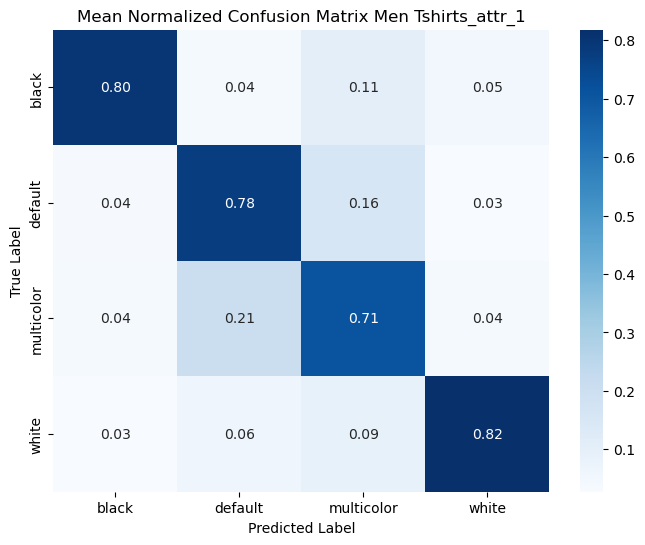

Men Tshirts:  20%|██        | 1/5 [00:14<00:58, 14.57s/it]

filtered in 0.5561196804046631
Processing for Men Tshirts_attr_2
['Pytorch_Men Tshirts_attr_2_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Men Tshirts_attr_2: 99.30%


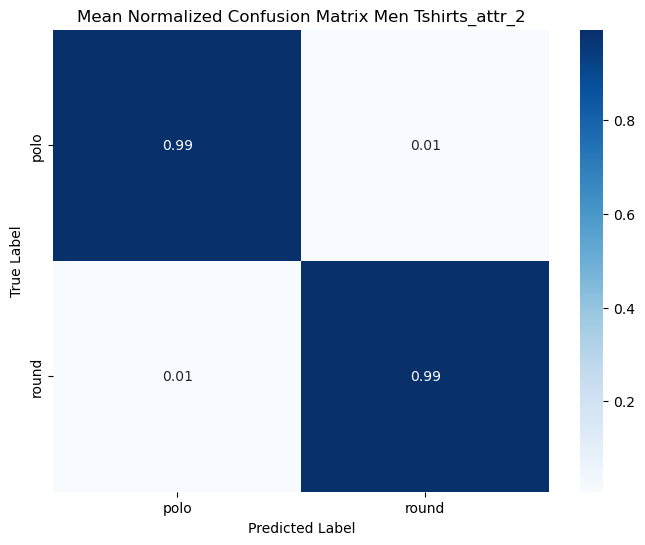

Men Tshirts:  40%|████      | 2/5 [00:21<00:30, 10.13s/it]

filtered in 0.5324888229370117
Processing for Men Tshirts_attr_3
['Pytorch_Men Tshirts_attr_3_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Men Tshirts_attr_3: 98.34%


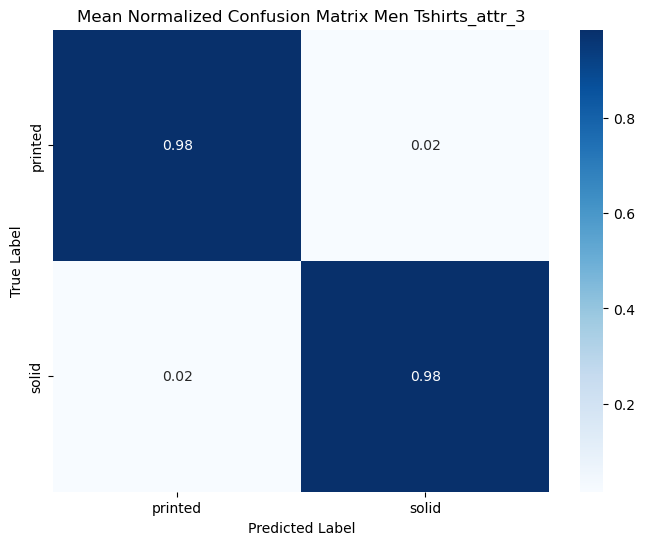

Men Tshirts:  60%|██████    | 3/5 [00:28<00:17,  8.71s/it]

filtered in 0.5353133678436279
Processing for Men Tshirts_attr_4
['Pytorch_Men Tshirts_attr_4_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Men Tshirts_attr_4: 91.38%


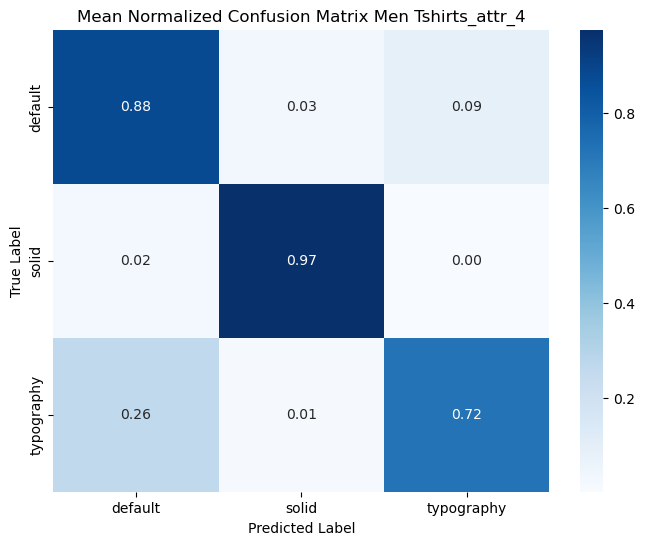

Men Tshirts:  80%|████████  | 4/5 [00:39<00:09,  9.51s/it]

filtered in 0.5269050598144531
Processing for Men Tshirts_attr_5
['Pytorch_Men Tshirts_attr_5_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Men Tshirts_attr_5: 99.11%


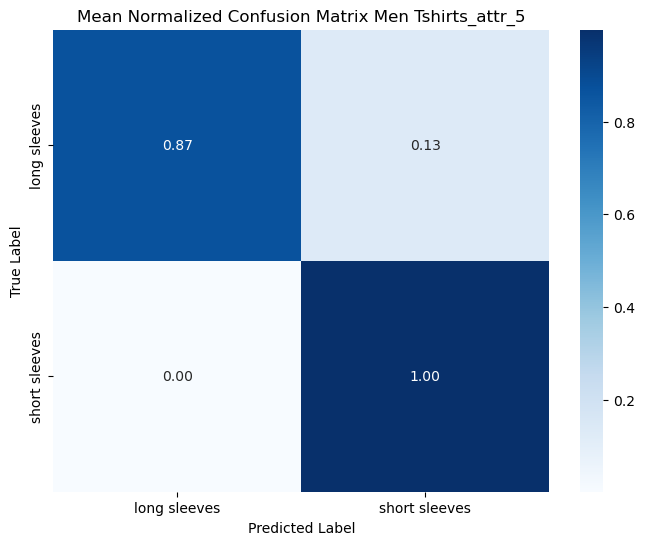

100%|██████████| 1197/1197 [00:11<00:00, 108.58it/s]


[]


Loading Images: 100%|██████████| 1197/1197 [00:06<00:00, 197.52it/s]


['007432.jpg', '007433.jpg', '007434.jpg', '007435.jpg', '007436.jpg', '007437.jpg', '007438.jpg', '007439.jpg', '007440.jpg', '007441.jpg', '007442.jpg', '007443.jpg', '007444.jpg', '007445.jpg', '007446.jpg', '007447.jpg', '007448.jpg', '007449.jpg', '007450.jpg', '007451.jpg', '007452.jpg', '007453.jpg', '007455.jpg', '007456.jpg', '007458.jpg', '007460.jpg', '007461.jpg', '007462.jpg', '007463.jpg', '007464.jpg', '007465.jpg', '007466.jpg', '007467.jpg', '007470.jpg', '007471.jpg', '007473.jpg', '007474.jpg', '007476.jpg', '007478.jpg', '007479.jpg', '007480.jpg', '007481.jpg', '007482.jpg', '007483.jpg', '007484.jpg', '007485.jpg', '007486.jpg', '007487.jpg', '007489.jpg', '007492.jpg', '007493.jpg', '007496.jpg', '007498.jpg', '007503.jpg', '007505.jpg', '007509.jpg', '007516.jpg', '007517.jpg', '007520.jpg', '007526.jpg', '007527.jpg', '007531.jpg', '007533.jpg', '007538.jpg', '007544.jpg', '007545.jpg', '007550.jpg', '007551.jpg', '007556.jpg', '007560.jpg', '007561.jpg', '0075

Sarees:   0%|          | 0/10 [00:00<?, ?it/s]

filtered in 0.029178619384765625
Processing for Sarees_attr_1
['Pytorch_Sarees_attr_1_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_1: 71.62%


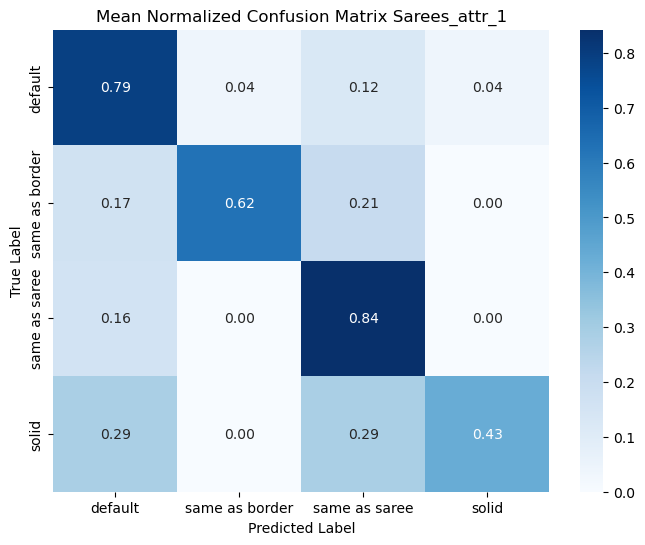

Sarees:  10%|█         | 1/10 [00:06<00:55,  6.17s/it]

filtered in 0.04245495796203613
Processing for Sarees_attr_2
['Pytorch_Sarees_attr_2_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_2: 80.00%


/tmp/ipykernel_4131879/1650785634.py:137: RuntimeWarning: invalid value encountered in divide
  mean_conf_matrix_normalized = mean_conf_matrix.astype('float') / mean_conf_matrix.sum(axis=1)[:, np.newaxis]


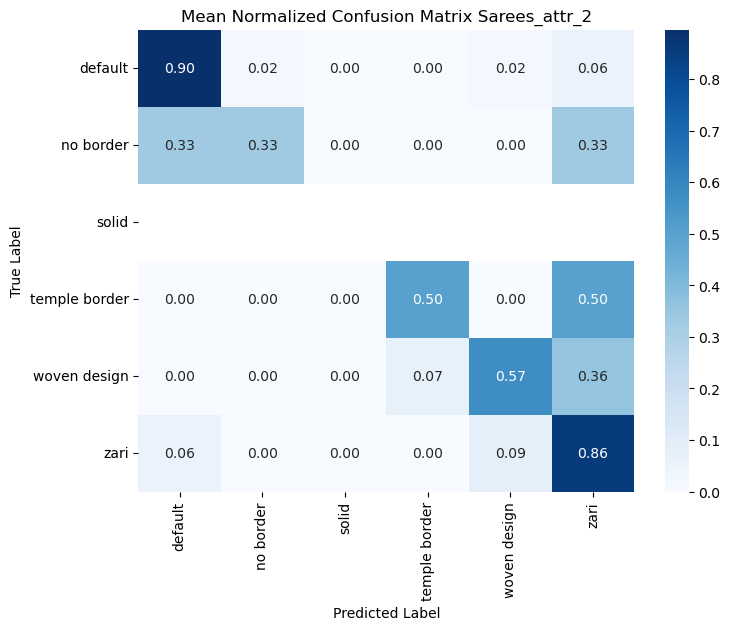

Sarees:  20%|██        | 2/10 [00:14<00:58,  7.37s/it]

filtered in 0.03328752517700195
Processing for Sarees_attr_3
['Pytorch_Sarees_attr_3_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_3: 77.65%


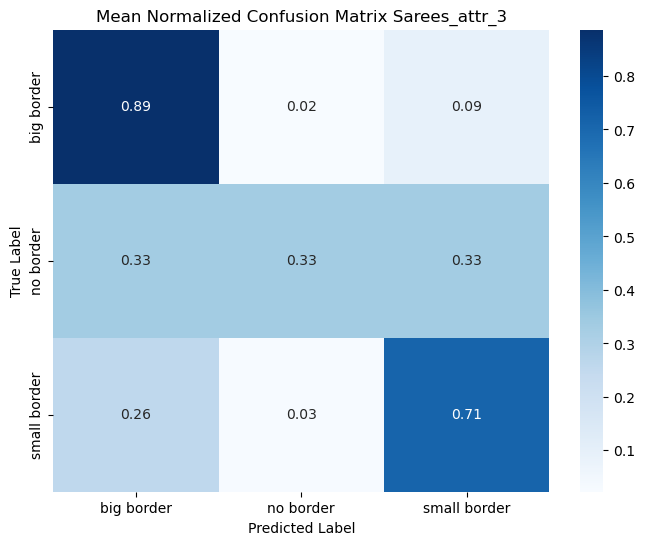

Sarees:  30%|███       | 3/10 [00:19<00:45,  6.48s/it]

filtered in 0.04045510292053223
Processing for Sarees_attr_4
['Pytorch_Sarees_attr_4_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_4: 60.75%


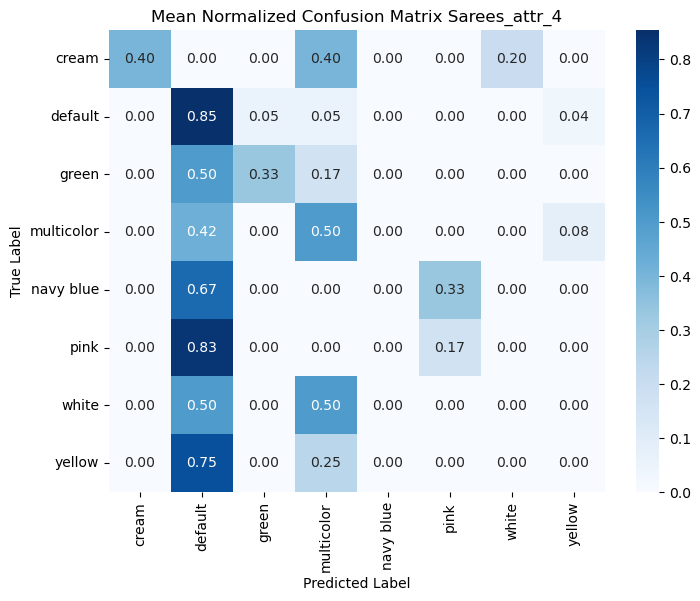

Sarees:  40%|████      | 4/10 [00:29<00:45,  7.66s/it]

filtered in 0.03580284118652344
Processing for Sarees_attr_5
['Pytorch_Sarees_attr_5_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_5: 76.40%


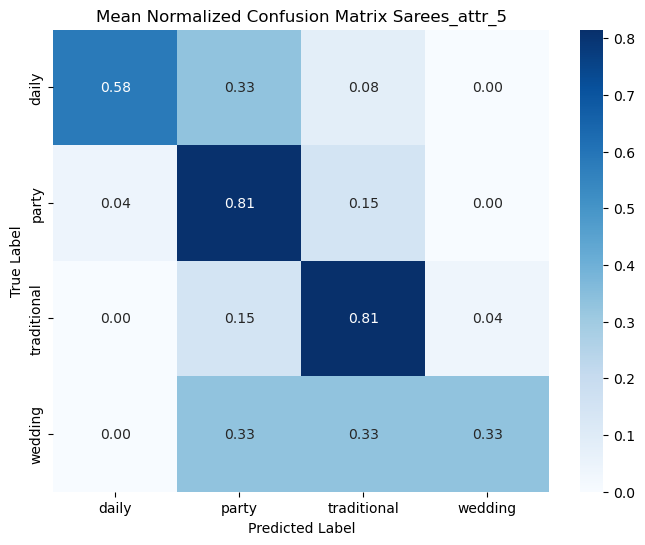

Sarees:  50%|█████     | 5/10 [00:35<00:36,  7.27s/it]

filtered in 0.026911497116088867
Processing for Sarees_attr_6
['Pytorch_Sarees_attr_6_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_6: 77.42%


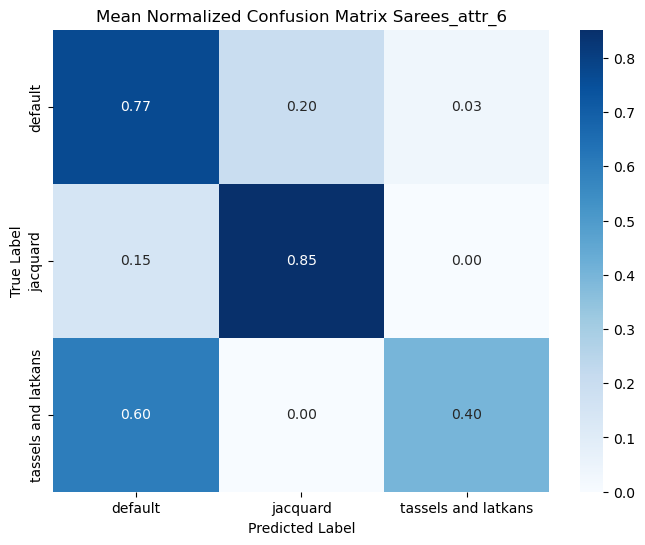

Sarees:  60%|██████    | 6/10 [00:40<00:25,  6.47s/it]

filtered in 0.03497815132141113
Processing for Sarees_attr_7
['Pytorch_Sarees_attr_7_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_7: 72.73%


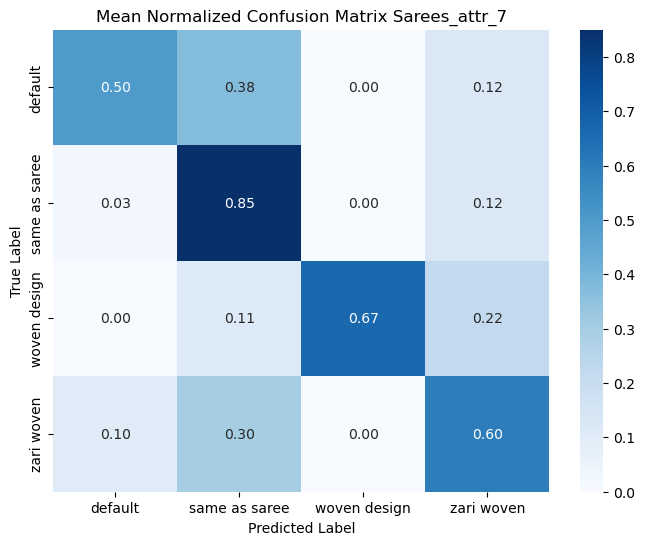

Sarees:  70%|███████   | 7/10 [00:47<00:19,  6.40s/it]

filtered in 0.03703665733337402
Processing for Sarees_attr_8
['Pytorch_Sarees_attr_8_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_8: 75.28%


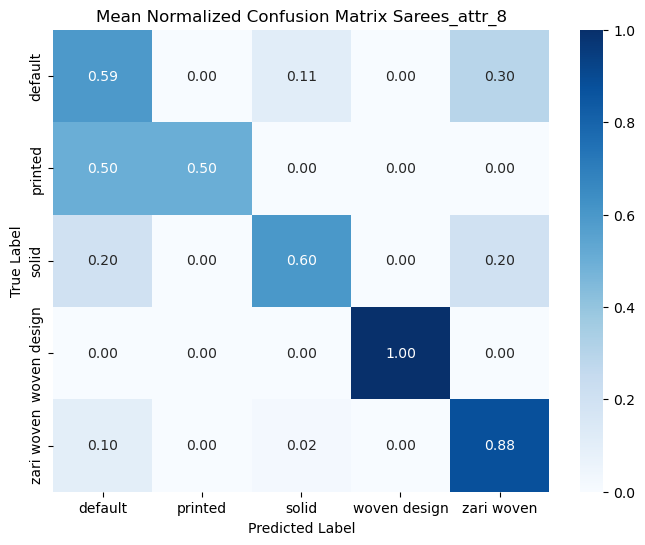

Sarees:  80%|████████  | 8/10 [00:53<00:13,  6.55s/it]

filtered in 0.03628897666931152
Processing for Sarees_attr_9
['Pytorch_Sarees_attr_9_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_9: 53.93%


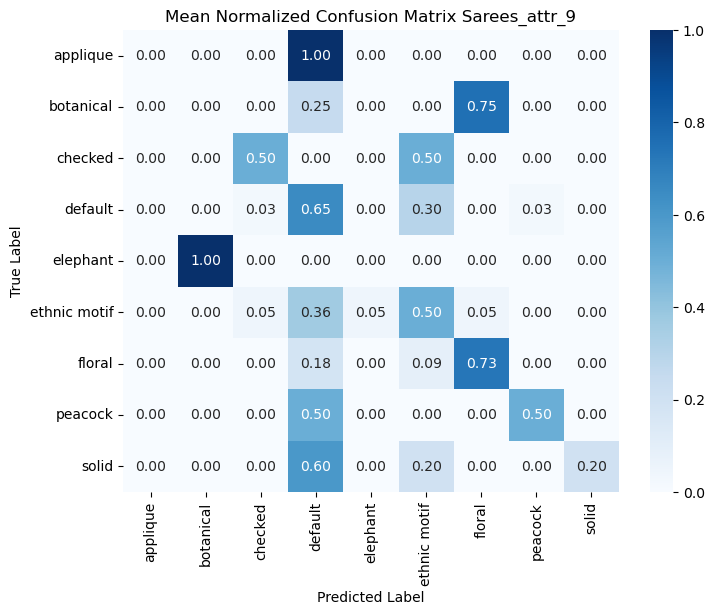

Sarees:  90%|█████████ | 9/10 [01:04<00:07,  7.73s/it]

filtered in 0.040040016174316406
Processing for Sarees_attr_10
['Pytorch_Sarees_attr_10_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Sarees_attr_10: 94.34%


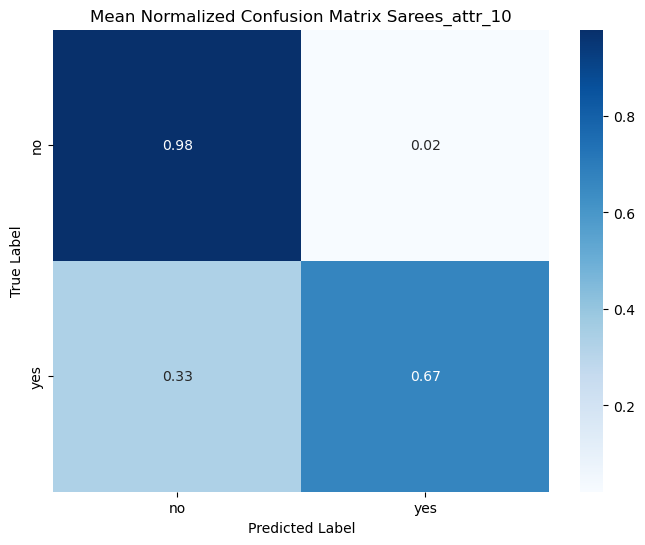

100%|██████████| 4059/4059 [00:37<00:00, 107.36it/s]


[]


Loading Images: 100%|██████████| 4059/4059 [00:11<00:00, 363.49it/s]


['025778.jpg', '025779.jpg', '025780.jpg', '025781.jpg', '025782.jpg', '025784.jpg', '025785.jpg', '025786.jpg', '025787.jpg', '025788.jpg', '025789.jpg', '025790.jpg', '025791.jpg', '025792.jpg', '025795.jpg', '025796.jpg', '025797.jpg', '025798.jpg', '025799.jpg', '025800.jpg', '025808.jpg', '025814.jpg', '025820.jpg', '025821.jpg', '025822.jpg', '025823.jpg', '025824.jpg', '025825.jpg', '025826.jpg', '025827.jpg', '025828.jpg', '025829.jpg', '025830.jpg', '025831.jpg', '025832.jpg', '025833.jpg', '025834.jpg', '025835.jpg', '025836.jpg', '025837.jpg', '025838.jpg', '025843.jpg', '025844.jpg', '025845.jpg', '025846.jpg', '025847.jpg', '025848.jpg', '025853.jpg', '025854.jpg', '025855.jpg', '025856.jpg', '025857.jpg', '025858.jpg', '025859.jpg', '025860.jpg', '025861.jpg', '025862.jpg', '025863.jpg', '025864.jpg', '025865.jpg', '025866.jpg', '025867.jpg', '025868.jpg', '025869.jpg', '025870.jpg', '025871.jpg', '025872.jpg', '025873.jpg', '025874.jpg', '025875.jpg', '025876.jpg', '0258

Kurtis:   0%|          | 0/9 [00:00<?, ?it/s]

filtered in 0.2688026428222656
Processing for Kurtis_attr_1
['Pytorch_Kurtis_attr_1_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_1: 76.79%


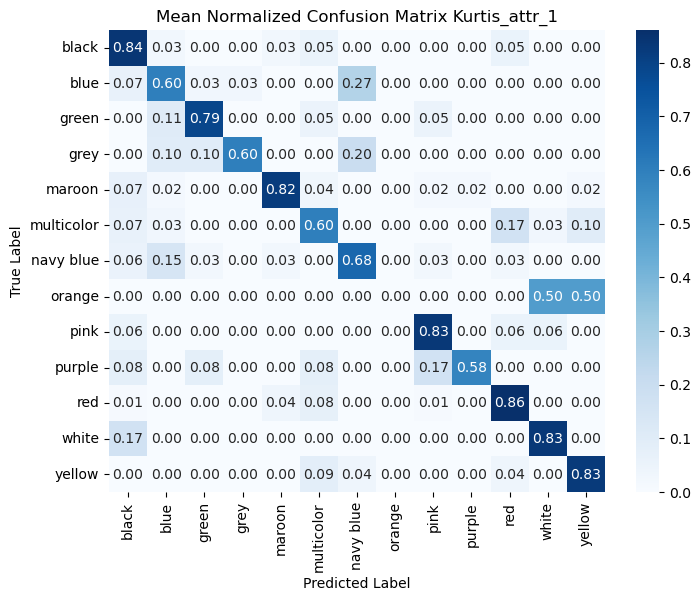

Kurtis:  11%|█         | 1/9 [00:21<02:52, 21.58s/it]

filtered in 0.18901920318603516
Processing for Kurtis_attr_2
['Pytorch_Kurtis_attr_2_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_2: 89.49%


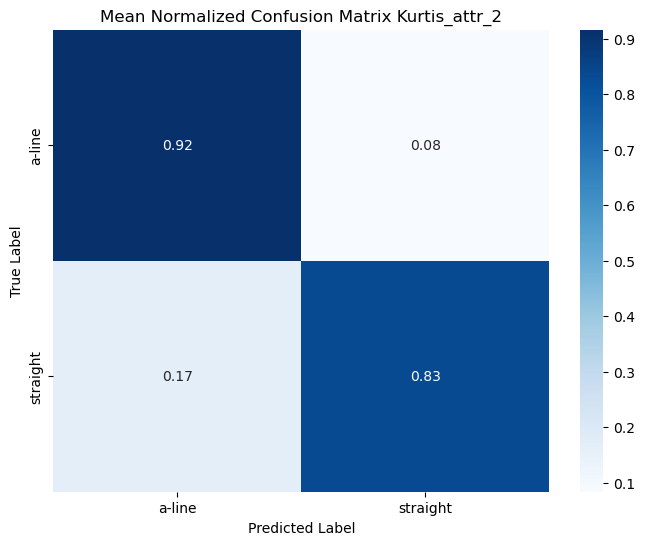

Kurtis:  22%|██▏       | 2/9 [00:27<01:24, 12.08s/it]

filtered in 0.19536876678466797
Processing for Kurtis_attr_3
['Pytorch_Kurtis_attr_3_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_3: 76.21%


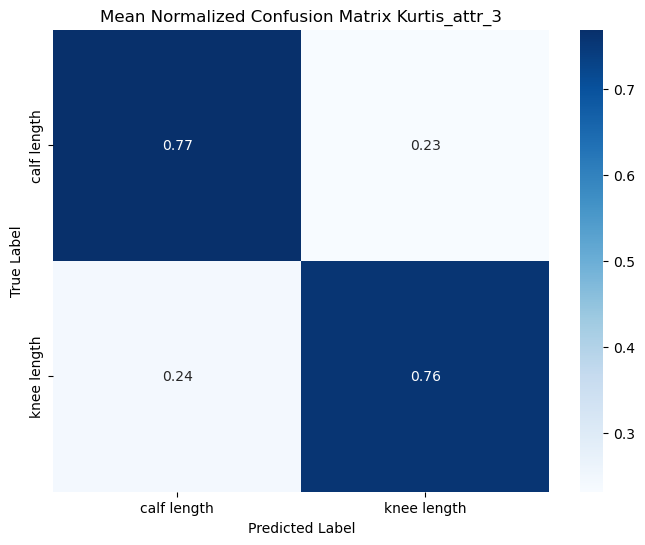

Kurtis:  33%|███▎      | 3/9 [00:32<00:55,  9.23s/it]

filtered in 0.27156805992126465
Processing for Kurtis_attr_4
['Pytorch_Kurtis_attr_4_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_4: 92.39%


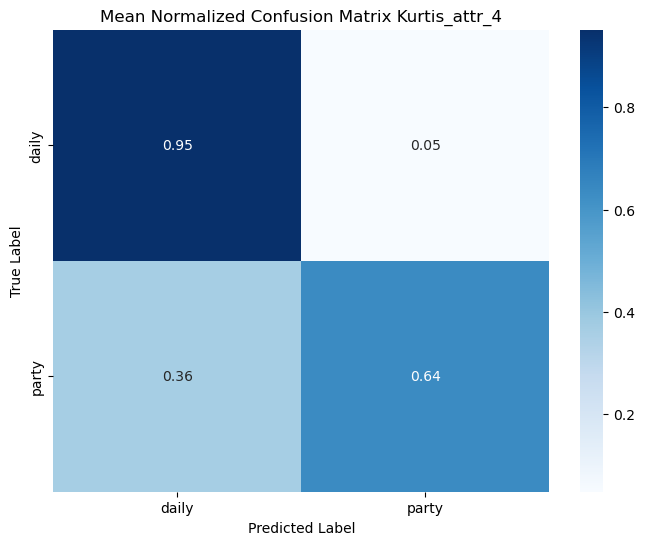

Kurtis:  44%|████▍     | 4/9 [00:39<00:40,  8.08s/it]

filtered in 0.18452215194702148
Processing for Kurtis_attr_5
['Pytorch_Kurtis_attr_5_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_5: 96.81%


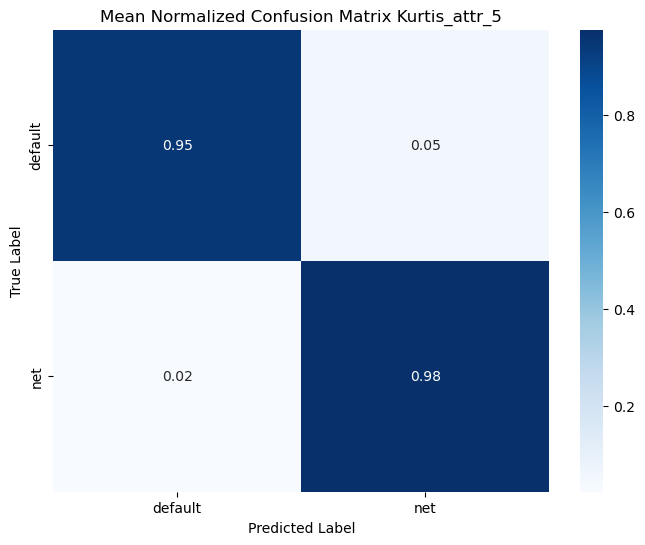

Kurtis:  56%|█████▌    | 5/9 [00:44<00:28,  7.02s/it]

filtered in 0.21132326126098633
Processing for Kurtis_attr_6
['Pytorch_Kurtis_attr_6_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_6: 91.50%


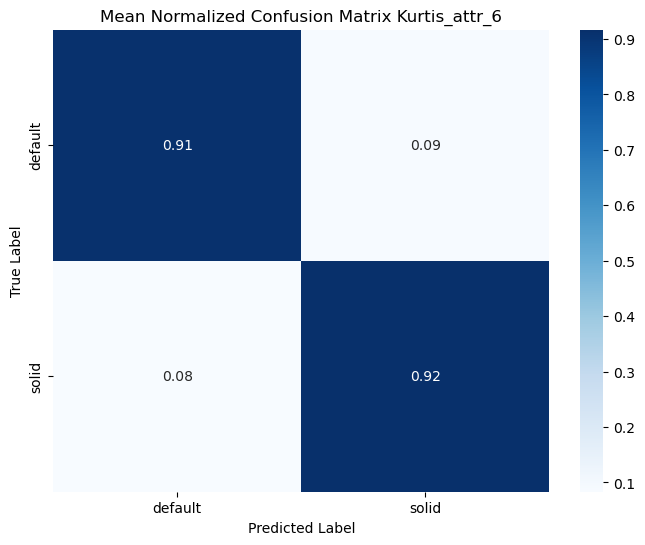

Kurtis:  67%|██████▋   | 6/9 [00:49<00:19,  6.55s/it]

filtered in 0.22821545600891113
Processing for Kurtis_attr_7
['Pytorch_Kurtis_attr_7_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_7: 92.48%


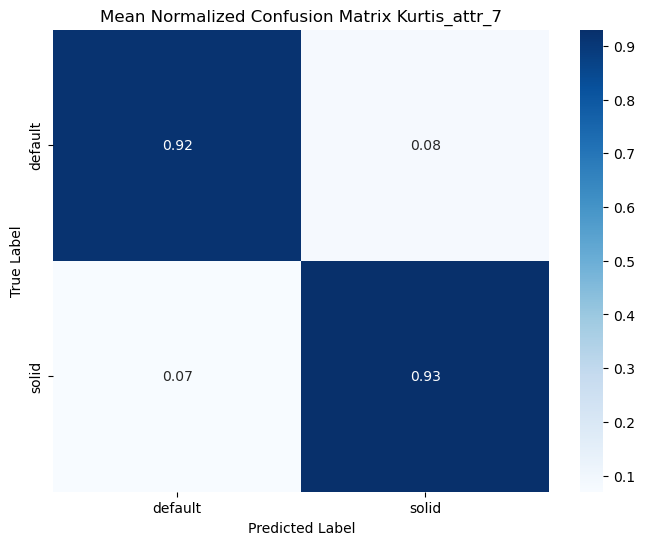

Kurtis:  78%|███████▊  | 7/9 [00:55<00:12,  6.24s/it]

filtered in 0.27637505531311035
Processing for Kurtis_attr_8
['Pytorch_Kurtis_attr_8_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_8: 95.47%


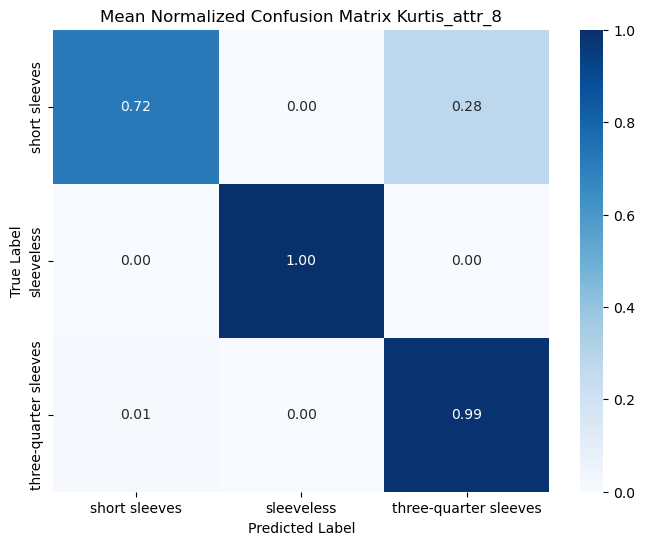

Kurtis:  89%|████████▉ | 8/9 [01:04<00:06,  6.98s/it]

filtered in 0.2747008800506592
Processing for Kurtis_attr_9
['Pytorch_Kurtis_attr_9_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep20_batch64.pth']


/tmp/ipykernel_4131879/1650785634.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')


XGB
 Validation Accuracy Kurtis_attr_9: 98.74%


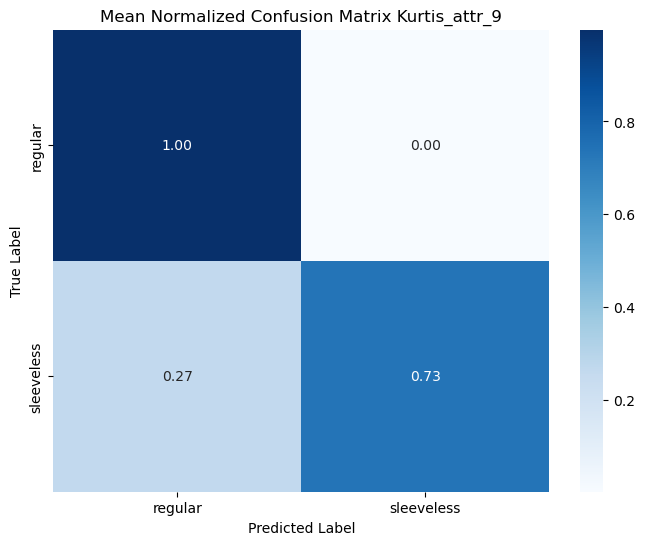

100%|██████████| 17859/17859 [02:47<00:00, 106.83it/s]


[]


Loading Images:  37%|███▋      | 6564/17859 [00:19<00:33, 334.91it/s]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os
from concurrent.futures import ThreadPoolExecutor


model_type = 'xgb'
le_dict = {}
model_dict = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for dataset_train,dataset_name,attr_names_for_this_dataset in zip(store_list,store_list_names,attributes_list):

    t2 = time.time()
    
    
    images_array_all = np.zeros((len(dataset_train[:]),224,224,3),dtype=np.uint8)
    filename_list_not = []
    c = 0
    for i in tqdm(range(len(dataset_train))): # Can we make this loading as an array faster
        if(dataset_train['filename'].iloc[i] in os.listdir(path)):
            c+=1
        else:
            filename_list_not.append(dataset_train['filename'].iloc[i])
            dataset_train.drop(dataset_train.index[i])
    print(filename_list_not)




    images_array_all = np.zeros((len(dataset_train[:]),224,224,3),dtype=np.uint8)
    filename_list = []
    c = 0
    for i in tqdm(range(len(dataset_train)),desc='Loading Images'): # Can we make this loading as an array faster
        try:
            images_array_all[c,:,:,:] = np.asarray(Image.open(f"{path}/{dataset_train['filename'].iloc[i]}").resize((224,224)),dtype=np.uint8)
            filename_list.append(dataset_train['filename'].iloc[i])
            c+=1
        except:
            dataset_train.drop(dataset_train.index[i])
    print(filename_list)
       
    print(f'Loaded Images in {time.time()-t2}')

    

    for attr_name in tqdm(attr_names_for_this_dataset, desc=f'{dataset_name}'):

        

        # Example usage with a sample input tensor
        # input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Batch size 1, 3 channels, 224x224 image
        # with torch.no_grad():
        #     features = feature_extractor(input_tensor)

        # print("Shape of convolutional features:", features.shape)
        label_all = dataset_train[attr_name][:].values

        t1 = time.time()
        train_train = dataset_train[dataset_train[attr_name]!='nan']
        train_train_filenames = train_train['filename'].values #attr corresponding to Names that don't contain nan
        
        indices = []
        for j,fname in enumerate(filename_list):
             if(fname in train_train_filenames):
                indices.append(j)
        images_array = images_array_all[indices,:,:,:]
        print(f'filtered in {time.time()-t1}')

        labels = label_all[indices]

        le_object = LabelEncoder()
        target = le_object.fit_transform(labels)
        identifier = dataset_name+'_'+attr_name
        print(f'Processing for {identifier}')




        le_dict[f'{identifier}'] = le_object # Store the label encoder object 
        class_names = le_object.classes_

        model = BuildingClassifierWithDropout(num_classes=len(class_names), resnet_version=50).to(device)
        # 'Pytorch_Men Tshirts_attr_1_Train_ResNET50_schedulerTrue_SMOTEFalse_optimadam_ep24_batch64.pth'
        mod_name = [i for i in os.listdir(path_to_res) if (f'{dataset_name}_{attr_name}_' in i)]
        print(mod_name)
        state_dict = torch.load(f'{path_to_res}/{mod_name[0]}')
        model.load_state_dict(state_dict)

        # Extract features up to the last convolutional layer
        # Use nn.Sequential to keep layers until 'layer4' (before FC)
        # feature_extractor = nn.Sequential(*(list(model.model.children())[:-1])).to(device)
        # feature_extractor.eval()
        resnet_model = nn.Sequential(*list(model.model.children())[:-1]).to(device)
        resnet_model.eval()

        X_train, X_val, y_train, y_val = train_test_split(images_array, target, train_size=0.9, stratify=target, random_state=42)

        # Create datasets and loaders for this fold
        train_dataset = BuildingDataset(X_train, y_train, transform=transform)
        val_dataset = BuildingDataset(X_val, y_val, transform=transform)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=32)
        val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False,num_workers=32)
        # all_loader = 

        train_features, train_labels = extract_features(resnet_model, train_loader)
        val_features, val_labels = extract_features(resnet_model, val_loader)

        # Train XGBoost
        if(model_type == 'xgb'):
            print('XGB')
            xgb = XGBClassifier(n_estimators=1000, max_depth=7,learning_rate=0.05, eval_metric='logloss', tree_method="hist", device="cuda", reg_lambda=0.01, random_state=42)
        # xgb.fit(train_features, train_labels, verbose=True)
        elif(model_type == 'rf'):
            print('RandomForest')
            xgb = RandomForestClassifier(n_estimators=500, max_depth=12, random_state=42,n_jobs=-1)
        elif(model_type=='svc'):
            xgb = SVC(kernel='rbf', C=3, gamma='scale', probability=True, random_state=42)
        elif(model_type == 'bag'):
            print('Bagging Classifier')
        # Instantiate the ensemble model
            xgb = CustomEnsembleClassifier()

        model_dict[f'{identifier}'] = xgb

        xgb.fit(train_features, train_labels)

        val_preds = xgb.predict(val_features)
        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f' Validation Accuracy {identifier}: {val_accuracy * 100:.2f}%')
        cm = confusion_matrix(val_labels, val_preds, labels=range(len(class_names)))

        # Compute the mean confusion matrix

        mean_conf_matrix = cm

        # Normalize the confusion matrix
        mean_conf_matrix_normalized = mean_conf_matrix.astype('float') / mean_conf_matrix.sum(axis=1)[:, np.newaxis]

        # Plot the mean normalized confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(mean_conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Mean Normalized Confusion Matrix {identifier}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# joblib.dump(model_dict,'CONVO_xgb_Trained_RESNET_Mode_dict.pkl')
# joblib.dump(le_dict,'_CONVO_xgb_Trained_RESNET_le_dictionary_7.pkl')